In [1]:
import h5py
import natsort
import time
import matplotlib.pyplot as plt

import numpy as np
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tf.get_logger().setLevel('ERROR')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # currently memory growth needs to be same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)

2024-02-02 06:21:04.648674: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 06:21:04.701019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 06:21:04.701066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 06:21:04.702643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 06:21:04.711455: I tensorflow/core/platform/cpu_feature_guar

2 Physical GPUs 2 Logical GPUs




2024-02-02 06:21:09.182570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21476 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:61:00.0, compute capability: 7.5
2024-02-02 06:21:09.183274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21476 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:db:00.0, compute capability: 7.5


In [44]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 4 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Batch size.
BATCH_SIZE = 16

# Number of training datapoints.
NTRAIN = 2048

# Number of testing datapoints.
NTEST = 512


In [3]:
def cart_polar(coords):
    """
    Transforms coordinates from Cartesian to polar coordinates with custom scaling.

    Parameters:
    - coords: A tuple or list containing the (i, j) coordinates to be transformed.

    Returns:
    - A tuple (rho, theta) representing the transformed coordinates.
    """
    i, j = coords[0], coords[1]
    # Calculate the radial distance with a scaling factor.
    rho = 2 * np.sqrt((i - neta / 2) ** 2 + (j - neta / 2) ** 2) * nx / neta
    # Calculate the angle in radians and adjust the scale to fit the specified range.
    theta = ((np.arctan2((neta / 2 - j), (i - neta / 2))) % (2 * np.pi)) * nx / np.pi / 2
    return theta, rho + neta // 2


In [4]:
# Precompute the transformation matrix from polar coordinates to Cartesian coordiantes 
cart_mat = np.zeros((neta**2, nx, nx))

for i in range(nx):
    for j in range(nx):
        # Create a dummy matrix with a single one at position (i, j) and zeros elsewhere.
        mat_dummy = np.zeros((nx, nx))
        mat_dummy[i, j] = 1
        # Pad the dummy matrix in polar coordinates to cover the target space in Cartesian coordinates.
        pad_dummy = np.pad(mat_dummy, ((0, 0), (neta // 2, neta // 2)), 'edge')
        # Apply the geometric transformation to map the dummy matrix to polar coordinates
        cart_mat[:, i, j] = geometric_transform(pad_dummy, cart_polar, output_shape=[neta, neta], mode='grid-wrap').flatten()

cart_mat = np.reshape(cart_mat, (neta**2, nx**2))
# Removing small values
cart_mat = np.where(np.abs(cart_mat) > 0.001, cart_mat, 0)
# Convert to sparse matrix in tensorflow
cart_mat = tf.sparse.from_dense(tf.cast(cart_mat, dtype='float32'))


2024-02-02 06:23:16.866743: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


In [45]:
name = 'testdata_shepp_logan'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTRAIN)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())
    
    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[4]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[5]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[1]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[2]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

# Create a TensorFlow dataset for training
trn_dataset = tf.data.Dataset.from_tensor_slices((scatter, eta_re))
trn_dataset = trn_dataset.prefetch(tf.data.experimental.AUTOTUNE)
trn_dataset = trn_dataset.shuffle(buffer_size=200)
trn_dataset = trn_dataset.batch(BATCH_SIZE)


In [46]:
# Rotation indices of rotated data matrices
def rotationindex(n):
    index = tf.reshape(tf.range(0, n**2, 1), [n, n])
    return tf.concat([tf.roll(index, shift=[-i,-i], axis=[0,1]) for i in range(n)], 0)


In [47]:
# The factors involved in butterfly factorization are represented by sparse matrices.
# This section focuses solely on the interaction between those factors and the data matrix.
# The original data is organized as a 2**L by 2**L block matrix, where each block is of size s by s.
# As butterfly layers are applied, the intermediate results transition to a block size of r by r.
# Ultimately, the final output produced by the last butterfly layer returns to a block size of s by s.

# Defining Layer V: This involves comparing the outputs generated by a specific einsum function with the transformation represented by x -> VxV*.
class V(tfkl.Layer):  
    def __init__(self, r):
        super().__init__()
        self.r = r

    def build(self, input_shape):
        self.get_re = tfkl.Lambda(lambda x : x[:,0,:,:,:,:,:]) 
        self.get_im = tfkl.Lambda(lambda x : x[:,1,:,:,:,:,:])
        self.n = tf.constant(input_shape[2])
        self.s = tf.constant(input_shape[3])
        self.c = tf.constant(input_shape[-1])
        self.vr = self.add_weight("vr", shape=[self.n,self.s,self.r,self.c])
        self.vi = self.add_weight("vi", shape=[self.n,self.s,self.r,self.c])
        
    def call(self, x): 
        x_re = self.get_re(x)
        x_im = self.get_im(x)
        y_re_1 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.vr)
        y_re_1 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_1, self.vr)
        y_re_2 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.vi)
        y_re_2 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_2, self.vi)
        y_re_3 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.vi)
        y_re_3 = -tf.einsum('abj...ic,bjkc->abk...ic', y_re_3, self.vr)
        y_re_4 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.vr)
        y_re_4 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_4, self.vi)
        y_re = y_re_1+y_re_2+y_re_3+y_re_4
        
        y_im_1 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.vr)
        y_im_1 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_1, self.vr)
        y_im_2 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.vi)
        y_im_2 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_2, self.vi)
        y_im_3 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.vi)
        y_im_3 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_3, self.vr)
        y_im_4 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.vr)
        y_im_4 = -tf.einsum('abj...ic,bjkc->abk...ic', y_im_4, self.vi)
        y_im = y_im_1+y_im_2+y_im_3+y_im_4
        
        y = tf.stack([y_re, y_im], axis=1)
        return y
    

In [48]:
# Precomputing indices used for grouping neighboring blocks prior to applying Layer Hs.
def build_permutation_indices(L, l):
    delta = 2**(L-l-1)
    tmp = np.tile(np.arange(2)*delta, delta)
    tmp += np.repeat(np.arange(delta), 2)
    tmp = np.tile(tmp, 2**l)
    tmp += np.repeat(np.arange(2**l)*(2**(L-l)), 2**(L-l))
    return tmp


In [49]:
# It might be helpful to print the outputs of build_permutation_indices and compare them with the transformation represented by x -> HxH*.
class H(tfkl.Layer):
    def __init__(self, L, l):
        super().__init__()
        self.L = L
        self.l = l
        self.perm_idx = tf.convert_to_tensor(build_permutation_indices(L,l))

    def build(self, input_shape):
        self.get_re = tfkl.Lambda(lambda x : x[:,0,:,:,:,:,:]) 
        self.get_im = tfkl.Lambda(lambda x : x[:,1,:,:,:,:,:])
        self.m = tf.constant(input_shape[2]//2)
        self.s = tf.constant(input_shape[3]*2)
        self.c = tf.constant(input_shape[-1])
        self.hr = self.add_weight("hr", shape=[self.m,self.s,self.s,self.c])
        self.hi = self.add_weight("hi", shape=[self.m,self.s,self.s,self.c])
        
    def call(self, x):
        x = tf.gather(x, self.perm_idx, axis=2)
        x = tf.gather(x, self.perm_idx, axis=4)
        x = tf.reshape(x, [-1,2,self.m,self.s,self.m,self.s,self.c])
        
        x_re = self.get_re(x)
        x_im = self.get_im(x)
        y_re_1 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.hr)
        y_re_1 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_1, self.hr)
        y_re_2 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.hi)
        y_re_2 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_2, self.hi)
        y_re_3 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.hi)
        y_re_3 = -tf.einsum('abj...ic,bjkc->abk...ic', y_re_3, self.hr)
        y_re_4 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.hr)
        y_re_4 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_4, self.hi)
        y_re = y_re_1+y_re_2+y_re_3+y_re_4
        
        y_im_1 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.hr)
        y_im_1 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_1, self.hr)
        y_im_2 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.hi)
        y_im_2 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_2, self.hi)
        y_im_3 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.hi)
        y_im_3 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_3, self.hr)
        y_im_4 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.hr)
        y_im_4 = -tf.einsum('abj...ic,bjkc->abk...ic', y_im_4, self.hi)
        y_im = y_im_1+y_im_2+y_im_3+y_im_4
        
        y = tf.stack([y_re, y_im], axis=1)
        
        n = self.m*2
        r = self.s//2
    
        y = tf.reshape(y, [-1,2,n,r,n,r,self.c])
        return y
    

In [50]:
# Precomputing indices used for redistributing blocks according to the transformation represented by x -> M*xM.
def build_switch_indices(L):
    L = L // 2
    tmp = np.arange(2**L)*(2**L)
    tmp = np.tile(tmp, 2**L)
    tmp += np.repeat(np.arange(2**L), 2**L)
    return tmp


In [51]:
class M(tfkl.Layer):  
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        self.get_re = tfkl.Lambda(lambda x : x[:,0,:,:,:,:,:]) 
        self.get_im = tfkl.Lambda(lambda x : x[:,1,:,:,:,:,:])
        self.n = tf.constant(input_shape[2])
        self.r = tf.constant(input_shape[3])
        self.c = tf.constant(input_shape[-1])
        self.mr = self.add_weight("mr", shape=[self.n,self.r,self.r,self.c])
        self.mi = self.add_weight("mi", shape=[self.n,self.r,self.r,self.c])
        
    def call(self, x):
        x_re = self.get_re(x)
        x_im = self.get_im(x)
        y_re_1 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.mr)
        y_re_1 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_1, self.mr)
        y_re_2 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.mi)
        y_re_2 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_2, self.mi)
        y_re_3 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.mi)
        y_re_3 = -tf.einsum('abj...ic,bjkc->abk...ic', y_re_3, self.mr)
        y_re_4 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.mr)
        y_re_4 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_4, self.mi)
        y_re = y_re_1+y_re_2+y_re_3+y_re_4
        
        y_im_1 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.mr)
        y_im_1 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_1, self.mr)
        y_im_2 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.mi)
        y_im_2 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_2, self.mi)
        y_im_3 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.mi)
        y_im_3 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_3, self.mr)
        y_im_4 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.mr)
        y_im_4 = -tf.einsum('abj...ic,bjkc->abk...ic', y_im_4, self.mi)
        y_im = y_im_1+y_im_2+y_im_3+y_im_4
        
        y = tf.stack([y_re, y_im], axis=1)
        return y
    

In [52]:
class G(tfkl.Layer):
    def __init__(self, L, l):
        super().__init__()
        self.L = L
        self.l = l
        self.perm_idx = tf.convert_to_tensor(build_permutation_indices(L,l))

    def build(self, input_shape):
        self.get_re = tfkl.Lambda(lambda x : x[:,0,:,:,:,:,:]) 
        self.get_im = tfkl.Lambda(lambda x : x[:,1,:,:,:,:,:])
        self.m = tf.constant(input_shape[2]//2)
        self.s = tf.constant(input_shape[3]*2)
        self.c = tf.constant(input_shape[-1])
        self.gr = self.add_weight("gr", shape=[self.m,self.s,self.s,self.c])
        self.gi = self.add_weight("gi", shape=[self.m,self.s,self.s,self.c])
        
    def call(self, x):
        x = tf.reshape(x, [-1,2,self.m,self.s,self.m,self.s,self.c])
        x_re = self.get_re(x)
        x_im = self.get_im(x)
        
        y_re_1 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.gr)
        y_re_1 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_1, self.gr)
        y_re_2 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.gi)
        y_re_2 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_2, self.gi)
        y_re_3 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.gi)
        y_re_3 = -tf.einsum('abj...ic,bjkc->abk...ic', y_re_3, self.gr)
        y_re_4 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.gr)
        y_re_4 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_4, self.gi)
        y_re = y_re_1+y_re_2+y_re_3+y_re_4
        
        y_im_1 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.gr)
        y_im_1 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_1, self.gr)
        y_im_2 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.gi)
        y_im_2 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_2, self.gi)
        y_im_3 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.gi)
        y_im_3 = tf.einsum('abj...ic,bjkc->abk...ic', y_im_3, self.gr)
        y_im_4 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.gr)
        y_im_4 = -tf.einsum('abj...ic,bjkc->abk...ic', y_im_4, self.gi)
        y_im = y_im_1+y_im_2+y_im_3+y_im_4
        
        y = tf.stack([y_re, y_im], axis=1)

        n = self.m*2
        r = self.s//2
        
        y = tf.reshape(y, [-1,2,n,r,n,r,self.c])
        y = tf.gather(y, self.perm_idx, axis=2)
        y = tf.gather(y, self.perm_idx, axis=4)
        return y
    

In [53]:
class U(tfkl.Layer):  
    def __init__(self, s):
        super().__init__()
        self.s = s

    def build(self, input_shape):
        self.get_re = tfkl.Lambda(lambda x : x[:,0,:,:,:,:,:]) 
        self.get_im = tfkl.Lambda(lambda x : x[:,1,:,:,:,:,:])
        self.n = tf.constant(input_shape[2])
        self.r = tf.constant(input_shape[3])
        self.c = tf.constant(input_shape[-1])
        self.ur = self.add_weight("ur", shape=[self.n,self.r,self.s,self.c])
        self.ui = self.add_weight("ui", shape=[self.n,self.r,self.s,self.c])
        
    def call(self, x): 
        x_re = self.get_re(x)
        x_im = self.get_im(x)
        y_re_1 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.ur)
        y_re_1 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_1, self.ur)
        y_re_2 = tf.einsum('...iajc,ajkc->...iakc', x_re, self.ui)
        y_re_2 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_2, self.ui)
        y_re_3 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.ui)
        y_re_3 = -tf.einsum('abj...ic,bjkc->abk...ic', y_re_3, self.ur)
        y_re_4 = tf.einsum('...iajc,ajkc->...iakc', x_im, self.ur)
        y_re_4 = tf.einsum('abj...ic,bjkc->abk...ic', y_re_4, self.ui)
        y_re = y_re_1+y_re_2+y_re_3+y_re_4
        return y_re
    

In [54]:
class Fstar(tf.keras.layers.Layer):
    def __init__(self, L, s, r, NUM_RESNET, cart_mat):
        super(Fstar, self).__init__()
        self.L = L
        self.s = s
        self.r = r
        self.n = 2**L
        self.nx = (2**L)*s
        self.neta = (2**L)*s
        # The number of resnet we use for Layer M
        self.NUM_RESNET = NUM_RESNET
        # Indices used for redistributing blocks
        self.switch_idx = tf.convert_to_tensor(build_switch_indices(L))
        # Rotation indices
        self.rindex = lambda d: tf.gather(tf.reshape(d, [-1]), rotationindex(nx))
        # Transformation matrix from polar coordinates to Cartesian coordiantes 
        self.cart_mat = cart_mat
        

    def build(self, input_shape):
        # Butterfly layers
        self.Vs = [V(self.r)]
        
        self.Hs = []
        for l in range(self.L-1, self.L//2-1, -1):
            d = self.L-l
            self.Vs.append(V(self.r))
            self.Hs.append(H(self.L,l))
        
        self.Ms = []
        for nn in np.arange(2*self.NUM_RESNET):
            self.Ms.append(M())
            
        self.Gs = []
        for l in range(self.L//2, self.L):
            self.Gs.append(G(self.L, l))
            
        self.U = U(self.s)
    
    def call(self, inputs): 
        # Attempting to use vectorized_map to parallelize the batch on the GPU for speed optimization.
        # Is there a better way to implement this?
        def helper(data): 
            # Apply rotation indices
            y1r = tf.reshape(self.rindex(data[0,:,:,0]), [-1,self.nx,self.nx,1])
            y1i = tf.reshape(self.rindex(data[1,:,:,0]), [-1,self.nx,self.nx,1])
            y2r = tf.reshape(self.rindex(data[0,:,:,1]), [-1,self.nx,self.nx,1])
            y2i = tf.reshape(self.rindex(data[1,:,:,1]), [-1,self.nx,self.nx,1])
            y3r = tf.reshape(self.rindex(data[0,:,:,2]), [-1,self.nx,self.nx,1])
            y3i = tf.reshape(self.rindex(data[1,:,:,2]), [-1,self.nx,self.nx,1])
            y1 = tf.stack((y1r, y1i), axis = 1)
            y2 = tf.stack((y2r, y2i), axis = 1)
            y3 = tf.stack((y3r, y3i), axis = 1)
            y = tfkl.Concatenate(axis=-1)([y1, y2, y3])
            # Reshape to 2**L by 2**L block matrix with block size of s by s
            y = tf.reshape(y, [-1,2,self.n,self.s,self.n,self.s,3])
            
            # Apply butterfly layers
            y = self.Vs[0](y)
            for l in range(self.L-1, self.L//2-1, -1):
                d = self.L-l
                y = self.Hs[d-1](y)
                
            y = tf.gather(y, self.switch_idx, axis=2)
            y = tf.gather(y, self.switch_idx, axis=4)
            
            for nn in np.arange(self.NUM_RESNET):
                if (nn+1)==self.NUM_RESNET:
                    y = self.Ms[nn](y)
                else:
                    y += tf.nn.relu(self.Ms[nn](y))
            
            for l in range(self.L//2, self.L):
                d = self.L-l
                y = self.Gs[-d](y)
            
            y = self.U(y)
            
            c = y.shape[-1]
            y = tf.reshape(y, [-1,self.nx,self.nx,c])
            # Take the diagonal only
            y = tf.linalg.diag_part(y)
            y = tf.reshape(y, [self.nx**2,c])
            # Convert from polar to Cartesian coordinates     
            y = tf.sparse.sparse_dense_matmul(self.cart_mat, y)

            return tf.reshape(y, (self.neta, self.neta, c))
        
        return tf.vectorized_map(helper, inputs) 
 

In [57]:
# The number of resnet we use for Layer M
NUM_RESNET = 3
#input_shape = (real & imaginary, nx, nx)
input_shape = (2, nx, nx, 3)
data = tfk.Input(shape = input_shape)

# Apply F^* on the data
y = Fstar(L, s, r, NUM_RESNET, cart_mat)(data)

# Application of (F^*F + epsilonI)^−1
NUM_CNN = 8
for nn in np.arange(NUM_CNN):
    k = 3
    if (nn+1)==NUM_CNN:
        y = tfkl.Conv2D(filters=1, kernel_size=(k, k), strides=(1, 1),
                    padding='same', activation=None)(y)
    else:
        act_fn = 'relu'
        nfilters = 6
        ytmp = tfkl.Conv2D(filters=nfilters, kernel_size=(k, k), strides=(1, 1),
                    padding='same', activation=act_fn)(y)
        y = tfkl.Concatenate(axis=-1)([y, ytmp])
    
alpha = tfkl.Reshape((neta, neta), name='RemoveChannelDim')(y)
    
model = tfk.Model(inputs=data, outputs=alpha)


In [58]:
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 2, 80, 80, 3)]       0         []                            
                                                                                                  
 fstar_7 (Fstar)             (None, 80, 80, 3)            20736     ['input_6[0][0]']             
                                                                                                  
 conv2d_40 (Conv2D)          (None, 80, 80, 6)            168       ['fstar_7[0][0]']             
                                                                                                  
 concatenate_37 (Concatenat  (None, 80, 80, 9)            0         ['fstar_7[0][0]',             
 e)                                                                  'conv2d_40[0][0]']     

In [59]:
# setup exponential scheduler
initial_learning_rate = 5e-3
lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps= 50,
            decay_rate=0.95,
            staircase=True)

opt = tf.optimizers.Adam(learning_rate=lr_schedule)

# instantiante model again inside strategy scope   
trn_loss_metric = tfk.metrics.Mean()

@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        X, yexact = inputs[0], inputs[1]
        
        y = model(X) # [?, nx, nx]
        se = (y - yexact)**2 # squared error [?, nx, nx]
        
        se_per_img = tf.reduce_sum(se, axis=[-2, -1])
        
        loss_per_img = se_per_img
        loss_per_batch = tf.reduce_mean(loss_per_img)
        
    # track metrics
    trn_loss_metric(loss_per_batch)
    
    # apply gradients
    grads = tape.gradient(loss_per_batch, model.trainable_weights)
    opt.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss_per_batch


Start of epoch 0-19


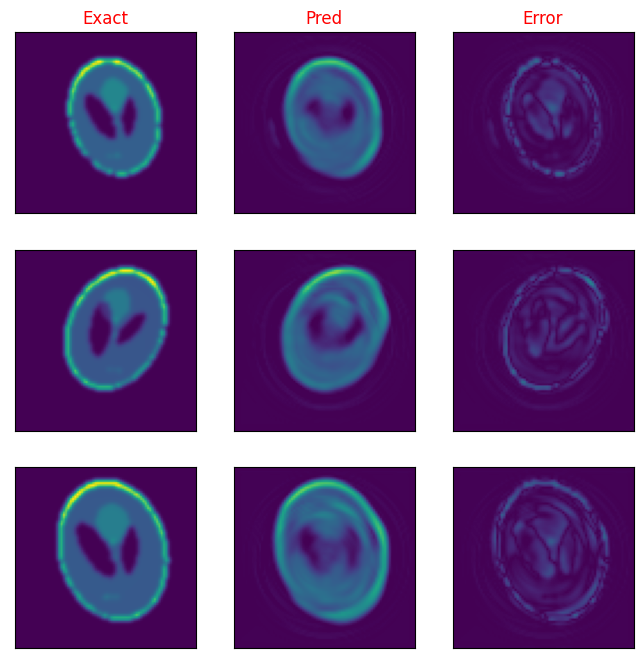

relative error = 28.165 %
Current epoch: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Time taken for 19 = 123.08s
Start of epoch 20-39


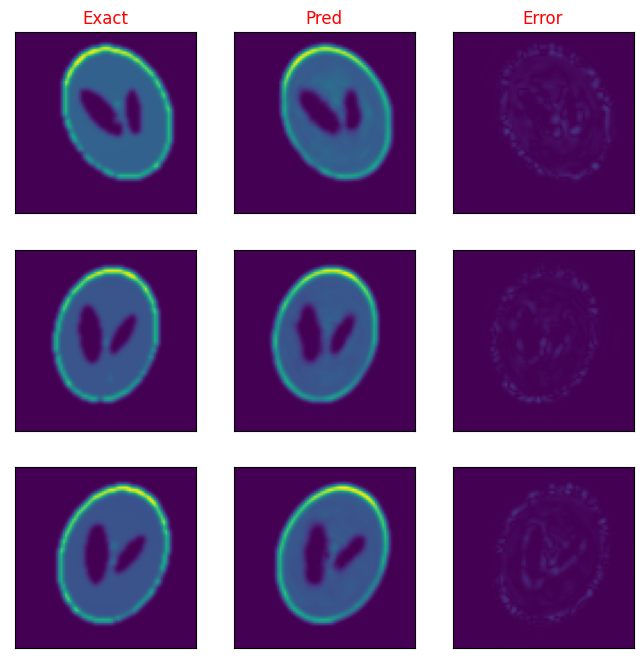

relative error = 9.627 %
Current epoch: 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
Time taken for 39 = 122.99s
Start of epoch 40-59


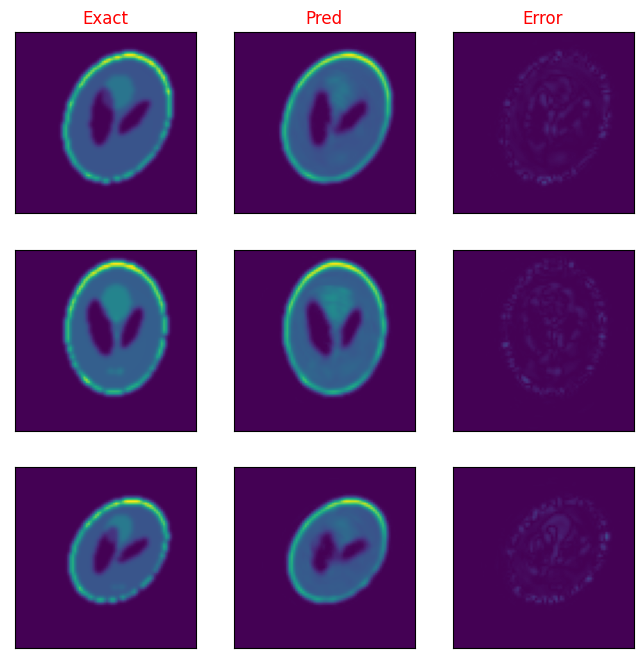

relative error = 9.557 %
Current epoch: 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Time taken for 59 = 123.02s
Start of epoch 60-79


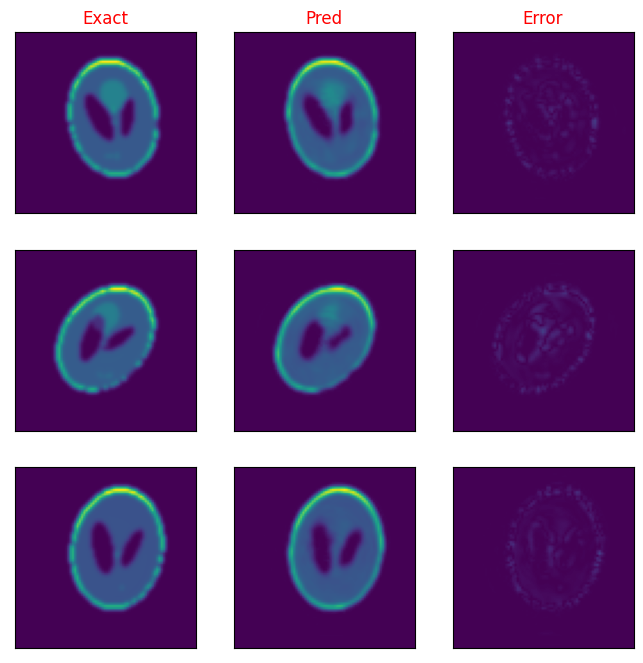

relative error = 9.001 %
Current epoch: 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
Time taken for 79 = 123.02s


In [60]:
NUM_EPOCHS = 80
try:
    for epoch in range(NUM_EPOCHS):      
        """ plot training results """
        start_time = time.perf_counter()
        for step, trn_batch in enumerate(trn_dataset):
            _ = train_step(trn_batch)
        duration = time.perf_counter()-start_time
        
        if epoch % 20 == 0:
            print(f'===================\nStart of epoch {epoch}-{epoch+19}')
            X, yexact = trn_batch[0], trn_batch[1]
            ypred = model(X) 
            
            err = tf.abs(ypred-yexact)
            errors = np.zeros(BATCH_SIZE)
            for i in range(BATCH_SIZE):
                errors[i] = np.sqrt(tf.reduce_sum(err[i,:,:]**2, axis=[-2, -1])
                               / tf.reduce_sum(yexact[i,:,:]**2, axis=[-2, -1]))
                
            plt.figure(figsize=(8,8))
            NPLOT = 3
            for kk in range(NPLOT):
                plt.subplot(NPLOT, 3, kk*NPLOT + 1)
                plt.imshow(yexact[kk,:,:])
                plt.xticks([]); plt.yticks([]); clim = plt.gci().get_clim();
                if kk == 0:
                    plt.title('Exact', color='red')
            
                plt.subplot(NPLOT, 3, kk*NPLOT + 2)
                plt.imshow(ypred[kk,:,:])
                plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
                if kk == 0:
                    plt.title('Pred', color='red')
            
                plt.subplot(NPLOT, 3, kk*NPLOT + 3)
                plt.imshow(err[kk,:,:])
                plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
                if kk == 0:
                    plt.title('Error', color='red')                
            plt.show()
            
            print('relative error = %.3f' % np.mean(100*errors), '%')
            print('Current epoch:', end =" ")
            
        print(epoch, end =" ")
            
        if epoch % 20 == 19:
            print(f'\nTime taken for {epoch} = %.2fs' % duration)
            
        trn_loss_metric.reset_states()
        
except KeyboardInterrupt:
    pass

In [101]:
# Process testing data
with h5py.File(name+'/eta.h5', 'r') as f: 
    eta_test = f[list(f.keys())[0]][NTRAIN:NTRAIN+NTEST,:].reshape(-1, neta, neta)
    blur_fn = lambda x : gaussian_filter(x, sigma=blur_sigma)
    eta_test = np.stack([blur_fn(eta_test[i,:,:]) for i in range(NTEST)]).astype('float32')
    
with h5py.File(name+'/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())
    # Process real part
    tmp1 = f[keys[3]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    tmp2 = f[keys[4]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    tmp3 = f[keys[5]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)
    # Process imaginary part
    tmp1 = f[keys[0]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    tmp2 = f[keys[1]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    tmp3 = f[keys[2]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    scatter_test = np.stack((scatter_re, scatter_im), axis=1).astype('float32')
    del scatter_re, scatter_im, tmp1, tmp2, tmp3
    

In [66]:
# Computing validation error 
val_errors = np.zeros(NTEST)
eta_pred = model(scatter_test)
val_err = tf.abs(eta_pred-eta_test)

for i in range(NTEST):
    val_errors[i] = np.sqrt(tf.reduce_sum(val_err[i,:,:]**2, axis=[-2, -1])
                          / tf.reduce_sum(eta_test[i,:,:]**2, axis=[-2, -1]))

print('validation error = %.3f' % np.mean(100*val_errors), '%') 
  

validation error = 9.034 %
